In [11]:
import re
from dataclasses import dataclass
import pandas as pd
import ffmpeg
import matplotlib.pyplot as plt

In [ ]:
@dataclass(frozen=True)
class TelemetryFrame:
    timestamp_sec: float
    longitude: float
    latitude: float
    gps_altitude: float
    distance_from_home: float
    height: float


# Regex pattern for parsing DJI SRT telemetry lines
TELEMETRY_PATTERN = re.compile(
    r"GPS\s*\(([\d.]+),\s*([\d.]+),\s*([-\d.]+)\),\s*"
    r"D\s*([\d.]+)m,\s*"
    r"H\s*([-\d.]+)m,\s*"
)

TIMESTAMP_PATTERN = re.compile(r"(\d+):(\d+):(\d+),(\d+)")


def extract_srt_content(video_path: str, stream_index: str = "0:2") -> str:
    """Extract subtitle stream from video to string.

    Args:
        video_path: Path to video file
        stream_index: Stream map index (default '0:2' for DJI subtitle)

    Returns:
        SRT content as string
    """
    out, _ = (
        ffmpeg.input(video_path)
        .output("pipe:", format="srt", map=stream_index)
        .run(capture_stdout=True, capture_stderr=True)
    )
    return out.decode("utf-8")


def parse_timestamp(timestamp_line: str) -> float | None:
    """Parse SRT timestamp to seconds."""
    match = TIMESTAMP_PATTERN.match(timestamp_line)
    if not match:
        return None
    h, m, s, ms = map(int, match.groups())
    return h * 3600 + m * 60 + s + ms / 1000


def parse_telemetry_line(data_line: str) -> dict | None:
    """Parse telemetry data from SRT content line."""
    match = TELEMETRY_PATTERN.search(data_line)
    if not match:
        return None
    return {
        "longitude": float(match.group(1)),
        "latitude": float(match.group(2)),
        "gps_altitude": float(match.group(3)),
        "distance_from_home": float(match.group(4)),
        "height": float(match.group(5)),
    }


def parse_srt_telemetry(srt_content: str) -> list[TelemetryFrame]:
    """Parse SRT telemetry content into structured frames.

    Args:
        srt_content: Raw SRT file content

    Returns:
        List of TelemetryFrame objects
    """
    frames: list[TelemetryFrame] = []
    blocks = re.split(r"\n\n+", srt_content.strip())

    for block in blocks:
        lines = block.strip().split("\n")
        if len(lines) < 3:
            continue

        timestamp = parse_timestamp(lines[1])
        if timestamp is None:
            continue

        telemetry = parse_telemetry_line(" ".join(lines[2:]))
        if telemetry is None:
            continue

        frames.append(TelemetryFrame(timestamp_sec=timestamp, **telemetry))

    return frames

In [ ]:
VIDEO_PATH = "...<input_path_here>"
srt_content = extract_srt_content(VIDEO_PATH)
frames = parse_srt_telemetry(srt_content)
srt_data = pd.DataFrame(frames)

In [7]:
srt_data.describe()

,timestamp_sec,longitude,latitude,gps_altitude,distance_from_home,height
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,314.500000,25.916575,48.263814,27.290476,310.599635,66.864286
std,182.009615,0.001868,0.001137,1.099098,172.354229,33.701781
min,0.000000,25.914000,48.262400,19.000000,1.840000,-1.500000
25%,157.250000,25.914600,48.262800,27.000000,212.852500,53.300000
50%,314.500000,25.917000,48.263400,28.000000,330.125000,54.450000
75%,471.750000,25.918100,48.264600,28.000000,454.245000,62.400000
max,629.000000,25.919300,48.265900,28.000000,519.010000,160.200000


<Axes: title={'center': 'Drone path simple'}, xlabel='longitude', ylabel='latitude'>

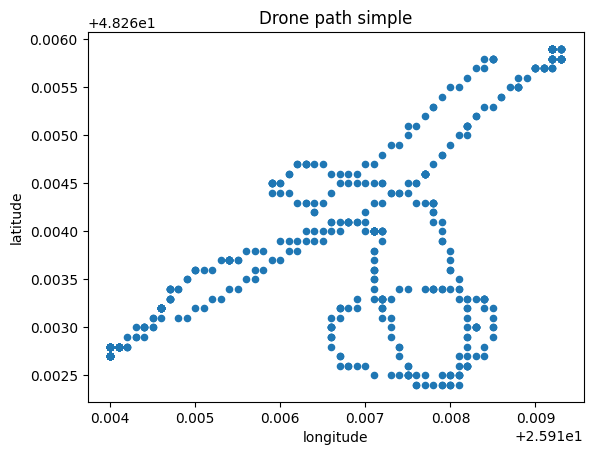

In [ ]:
srt_data.plot(kind="scatter", x="longitude", y="latitude", title="Drone path simple")

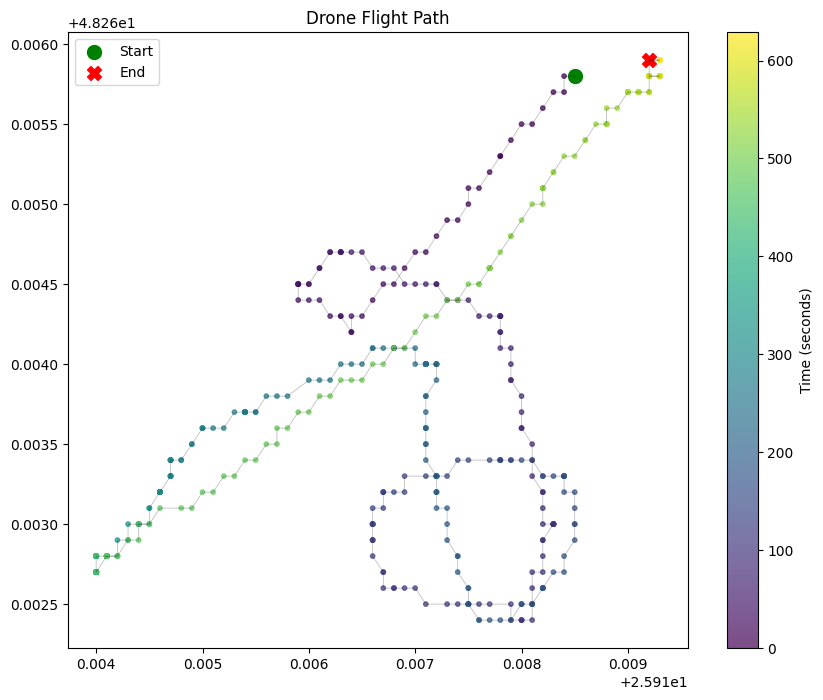

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(
    srt_data["longitude"],
    srt_data["latitude"],
    c=srt_data.index,
    cmap="viridis",
    s=10,
    alpha=0.7,
)

ax.plot(srt_data["longitude"], srt_data["latitude"], "k-", alpha=0.3, linewidth=0.5)

# Mark start and end
ax.scatter(
    *srt_data[["longitude", "latitude"]].iloc[0],
    c="green",
    s=100,
    marker="o",
    label="Start",
)
ax.scatter(
    *srt_data[["longitude", "latitude"]].iloc[-1],
    c="red",
    s=100,
    marker="X",
    label="End",
)

plt.colorbar(scatter, label="Time (seconds)")
ax.legend()
ax.set_title("Drone Flight Path")
plt.show()

In [16]:
srt_data[["longitude", "latitude"]].iloc[0]

longitude    25.9185
latitude     48.2658
Name: 0, dtype: float64